## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [1]:
from get_data import unpack
unpack('facial-keypoints-data.zip')

ImportError: bad magic number in 'get_data': b'\x03\xf3\r\n'

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [5]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import numpy as np

def load_imgs_and_keypoints(dirname='data'):
    # Write your code for loading images and points here
    data = pd.read_csv(dirname + '/gt.csv')
    N = data.shape[0]
    points_arr = np.array(data[data.columns[1:]].as_matrix(), dtype=np.float32)
    points = np.zeros_like(points_arr, dtype=np.float32)
    imgs = np.zeros((N, 100, 100, 3)) #fetching a size of 100 * 100 for image scaling
    #scaling process
    for i in range(N):
        img = imread(dirname + '/images/' + data.filename[i])
        w = img.shape[1]
        h = img.shape[0]
        points[i,:] = points_arr[i,:] / np.tile([w,h], 14) - 0.5
        img = resize(img, (100,100, 3))
        imgs[i,:,:,:] = img
        
    return imgs, points     

imgs, points = load_imgs_and_keypoints()

C:\Users\moataz\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\moataz\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


C:\Users\moataz\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


array([-0.36144578,  0.19879518, -0.26506025,  0.        , -0.21686748,
       -0.15662651, -0.1626506 , -0.38554215, -0.28313252,  0.19277108,
       -0.25903615,  0.07831325, -0.21686748,  0.02409638, -0.14457831,
       -0.13855422, -0.14457831, -0.25301206, -0.12650603, -0.31325302,
        0.04819277,  0.01807229,  0.13855422,  0.23493975,  0.19277108,
        0.10240964,  0.22891566, -0.01204819], dtype=float32)

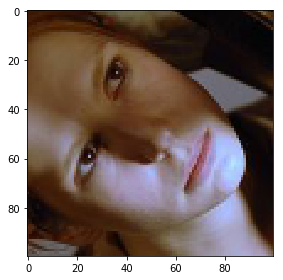

In [8]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[2])
points[2]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

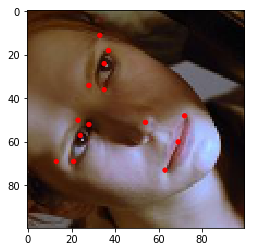

In [10]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.imshow(img)
    
    points_int = np.clip(np.array((points+0.5)*100, dtype=np.int32), 0, 99) #points vector
    
    for i in range(14):
        c = Circle((points_int[2*i], points_int[2*i+1]), radius=1, color='red')
        ax.add_patch(c)
    
visualize_points(imgs[2], points[2])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [11]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

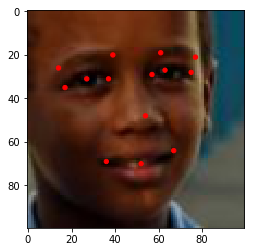

In [12]:
def flip_img(img, points):
    # Write your code for flipping here
    flip_image = img[:,::-1,:]
    
    flip_points = np.copy(points)
    
    for i in range(14):
        flip_points[2*i] = -points[2*i]
    return flip_image, flip_points


f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [13]:
n = imgs_train.shape[0]

aug_imgs_train = np.zeros((2*n, 100, 100, 3))
aug_points_train = np.zeros((2*n, 28))

for i in range(n):
    aug_imgs_train[2*i] = imgs_train[i]
    aug_points_train[2*i] = points_train[i]
    
    f_img, f_points = flip_img(imgs_train[i], points_train[i]) #flipping all 'count' number of images
    
    aug_imgs_train[2*i+1] = f_img
    aug_points_train[2*i+1] = f_points

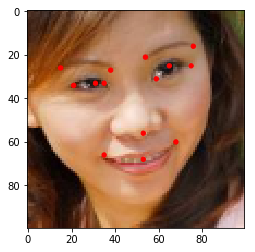

In [14]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

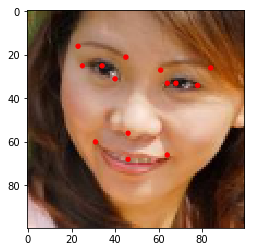

In [15]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [16]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout
)

model = Sequential()

model.add(Conv2D(filters=32,  kernel_size=(3,3), padding='valid', activation='relu', input_shape=(100,100,3)))
model.add(Conv2D(filters=32,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=64,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=128,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(Conv2D(filters=256,  kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=28, activation=None))

model.summary()

# Define here your model

C:\Users\moataz\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
con

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [17]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(aug_imgs_train, aug_points_train, batch_size=128, shuffle=True, epochs=5)
# Choose optimizer, compile model and run training

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/5
10800/10800 [==============================] - 1365s - loss: 0.0304  
Epoch 2/5
10800/10800 [==============================] - 1173s - loss: 0.0204  
Epoch 3/5
10800/10800 [==============================] - 1389s - loss: 0.0198  
Epoch 4/5
10800/10800 [==============================] - 1330s - loss: 0.0195  
Epoch 5/5
10800/10800 [==============================] - 1177s - loss: 0.0193  


### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

[50.62157  23.940844 50.348305 23.022312 49.660973 22.688612 49.485687
 22.698212 50.7095   31.754272 50.36601  31.304148 50.250977 31.87648
 49.8217   31.718153 49.514927 30.612846 49.490517 31.05523  50.05188
 52.038105 50.450005 68.037704 50.111588 68.74949  49.76223  67.54673 ]


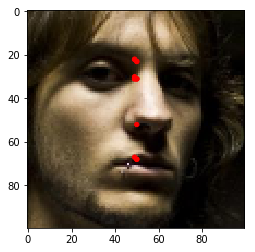

In [21]:
# Example of output
i = 10
img = imgs_val[i:i+1]
img_points = points_val[i:i+1]
pred_points = model.predict(img)[0]
visualize_points(img[0], pred_points)
print((pred_points+0.5)*100)